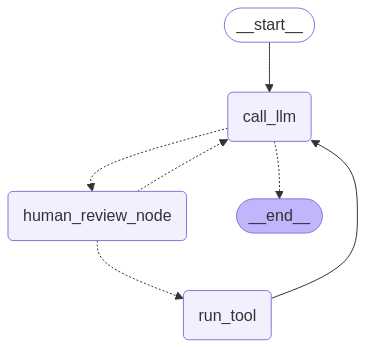

In [1]:

from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.tools import tool
from langchain_core.messages import AIMessage
from IPython.display import Image, display
from pydantic import BaseModel, Field
from langchain_ollama import ChatOllama


@tool
def fetch_todo_items():
    """Fetch todo items from the system."""

    return f"去北京参加会议，团队聚餐报销"

@tool
def initiate_process(reason: str, amount: float, department: str):
    """Initiate a process in the system."""
    return f"报销流程已发起"

class ProcessInfomation(BaseModel):
    """Process information."""

    amount: int = Field(
        description="The amount of money to be processed."
    )
    reason: str = Field(description="The reason for the processing.")
    department: str = Field(description="The department of the processing.")

    class Config:
        json_schema_extra = {
            "example": {
                "amount": 10,
                "reason": "团队聚餐",
                "department": "IT"
            }
        }


model = ChatOllama(model="qwen2.5:14b").bind_tools(
    [fetch_todo_items, initiate_process, ProcessInfomation]
)


class State(MessagesState):
    """Simple state."""


def call_llm(state):
    return {"messages": [model.invoke(state["messages"])]}


def human_review_node(state) -> Command[Literal["call_llm", "run_tool"]]:
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[-1]
    tool_name = tool_call["name"]

    if tool_name != "initiate_process":
        return Command(goto="run_tool")
    # this is the value we'll be providing via Command(resume=<human_review>)
    human_review = interrupt(
        {
            "question": "Is this correct?",
            # Surface tool calls for review
            "tool_call": tool_call,
        } 
    )

    review_action = human_review["action"]
    review_data = human_review.get("data")

    # if approved, call the tool
    if review_action == "continue":
        return Command(goto="run_tool")

    # update the AI message AND call tools
    elif review_action == "update":
        updated_message = {
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [
                {
                    "id": tool_call["id"],
                    "name": tool_call["name"],
                    # This the update provided by the human
                    "args": review_data,
                }
            ],
            # This is important - this needs to be the same as the message you replacing!
            # Otherwise, it will show up as a separate message
            "id": last_message.id,
        }
        return Command(goto="run_tool", update={"messages": [updated_message]})

    # provide feedback to LLM
    elif review_action == "feedback":
        # NOTE: we're adding feedback message as a ToolMessage
        # to preserve the correct order in the message history
        # (AI messages with tool calls need to be followed by tool call messages)
        tool_message = {
            "role": "tool",
            # This is our natural language feedback
            "content": review_data,
            "name": tool_call["name"],
            "tool_call_id": tool_call["id"],
        }
        return Command(goto="call_llm", update={"messages": [tool_message]})


def run_tool(state):
    new_messages = []
    tools = {"ProcessInfomation": ProcessInfomation, "fetch_todo_items": fetch_todo_items, "initiate_process": initiate_process}
    tool_calls = state["messages"][-1].tool_calls
    for tool_call in tool_calls:
        tool = tools[tool_call["name"]]
        result = tool.invoke(tool_call["args"])
        new_messages.append(
            {
                "role": "tool",
                "name": tool_call["name"],
                "content": result,
                "tool_call_id": tool_call["id"],
            }
        )
    return {"messages": new_messages}


def route_after_llm(state) -> Literal[END, "human_review_node"]:
    if len(state["messages"][-1].tool_calls) == 0:
        return END
    else:
        return "human_review_node"


builder = StateGraph(State)
builder.add_node(call_llm)
builder.add_node(run_tool)
builder.add_node(human_review_node)
builder.add_edge(START, "call_llm")
builder.add_conditional_edges("call_llm", route_after_llm)
builder.add_edge("run_tool", "call_llm")

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [2]:
# Input
initial_input = {"messages": [{"role": "user", "content": "hi!"}]}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'call_llm': {'messages': [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'qwen2.5:14b', 'created_at': '2025-04-02T06:10:20.37387Z', 'done': True, 'done_reason': 'stop', 'total_duration': 865160167, 'load_duration': 29799917, 'prompt_eval_count': 306, 'prompt_eval_duration': 601129208, 'eval_count': 10, 'eval_duration': 231882834, 'message': Message(role='assistant', content='Hello! How can I assist you today?', images=None, tool_calls=None)}, id='run-10b36228-e96a-4637-bbaa-87b24b32f1c8-0', usage_metadata={'input_tokens': 306, 'output_tokens': 10, 'total_tokens': 316})]}}




In [3]:
# Input
initial_input = {"messages": [{"role": "user", "content": "我的待办事项有哪些？"}]}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:14b', 'created_at': '2025-04-02T06:10:21.467625Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1065767417, 'load_duration': 8751542, 'prompt_eval_count': 331, 'prompt_eval_duration': 125777875, 'eval_count': 37, 'eval_duration': 928262125, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-a1f02831-f0dd-41b4-b74a-8c8e2bc12357-0', tool_calls=[{'name': 'fetch_todo_items', 'args': {}, 'id': 'a47802e6-48ff-4b66-9d88-8f7ed70b72a4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 331, 'output_tokens': 37, 'total_tokens': 368})]}}


{'human_review_node': None}


{'run_tool': {'messages': [{'role': 'tool', 'name': 'fetch_todo_items', 'content': '去北京参加会议，团队聚餐报销', 'tool_call_id': 'a47802e6-48ff-4b66-9d88-8f7ed70b72a4'}]}}


{'call_llm': {'messages': [AIMessage(content='您的待办事项包括：去北京参加一个会议，以及处理一次团队聚餐的报销事宜。需要进一步帮助吗？例如，我可以帮您启动这些任务中的任何一个流程

In [4]:
# Input
initial_input = {"messages": [{"role": "user", "content": "我要申请报销"}]}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'call_llm': {'messages': [AIMessage(content='好的，为了更好地协助您，请提供以下信息：\n- 报销金额是多少？\n- 本次报销所属的部门是哪个？\n- 报销的原因是什么？\n\n您可以将这些详细信息告诉我，然后我将为您启动相应的流程。', additional_kwargs={}, response_metadata={'model': 'qwen2.5:14b', 'created_at': '2025-04-02T06:10:24.370947Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1452838166, 'load_duration': 7859250, 'prompt_eval_count': 434, 'prompt_eval_duration': 125936125, 'eval_count': 51, 'eval_duration': 1311660042, 'message': Message(role='assistant', content='好的，为了更好地协助您，请提供以下信息：\n- 报销金额是多少？\n- 本次报销所属的部门是哪个？\n- 报销的原因是什么？\n\n您可以将这些详细信息告诉我，然后我将为您启动相应的流程。', images=None, tool_calls=None)}, id='run-a15e1d41-34aa-4e0c-9449-20611a46670b-0', usage_metadata={'input_tokens': 434, 'output_tokens': 51, 'total_tokens': 485})]}}




In [5]:
# Input
initial_input = {"messages": [{"role": "user", "content": "金额100元"}]}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'call_llm': {'messages': [AIMessage(content='还需要明确一下具体的信息，请问这笔100元的报销属于哪个部门？以及报销的具体原因是什么呢？这样我可以帮助您更准确地完成申请。', additional_kwargs={}, response_metadata={'model': 'qwen2.5:14b', 'created_at': '2025-04-02T06:10:25.43215Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1039722709, 'load_duration': 8204459, 'prompt_eval_count': 499, 'prompt_eval_duration': 126215416, 'eval_count': 35, 'eval_duration': 895839584, 'message': Message(role='assistant', content='还需要明确一下具体的信息，请问这笔100元的报销属于哪个部门？以及报销的具体原因是什么呢？这样我可以帮助您更准确地完成申请。', images=None, tool_calls=None)}, id='run-fa75705e-02ea-4457-a3ca-e9cbb0cf63ce-0', usage_metadata={'input_tokens': 499, 'output_tokens': 35, 'total_tokens': 534})]}}




In [6]:
# Input
initial_input = {"messages": [{"role": "user", "content": "部门研究院，请客户吃饭"}]}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:14b', 'created_at': '2025-04-02T06:10:30.563102Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1246204667, 'load_duration': 27088125, 'prompt_eval_count': 548, 'prompt_eval_duration': 255407209, 'eval_count': 37, 'eval_duration': 950532541, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-8036f46a-b552-4259-9898-6b4b4a796155-0', tool_calls=[{'name': 'initiate_process', 'args': {'amount': 100, 'department': '研究院', 'reason': '请客户吃饭'}, 'id': '574d771f-cc4a-436d-834f-efd36f0af4ed', 'type': 'tool_call'}], usage_metadata={'input_tokens': 548, 'output_tokens': 37, 'total_tokens': 585})]}}


{'__interrupt__': (Interrupt(value={'question': 'Is this correct?', 'tool_call': {'name': 'initiate_process', 'args': {'amount': 100, 'department': '研究院', 'reason': '请客户吃饭'}, 'id': '574d771f-cc4a-436d-834f-efd36f0af4ed', 'type': 'tool_call'}}, resuma

In [8]:
# Input
initial_input = {"messages": [{"role": "user", "content": "查下我的待办"}]}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:14b', 'created_at': '2025-04-02T06:11:08.917102Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1054914916, 'load_duration': 26618791, 'prompt_eval_count': 652, 'prompt_eval_duration': 245506541, 'eval_count': 29, 'eval_duration': 753277375, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-3a7d78cf-6407-4fe6-849e-aa2cafd3c651-0', tool_calls=[{'name': 'fetch_todo_items', 'args': {}, 'id': '1d905445-969b-4517-8790-f440e5fd31b0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 652, 'output_tokens': 29, 'total_tokens': 681})]}}


{'human_review_node': None}


{'run_tool': {'messages': [{'role': 'tool', 'name': 'fetch_todo_items', 'content': '去北京参加会议，团队聚餐报销', 'tool_call_id': '1d905445-969b-4517-8790-f440e5fd31b0'}]}}


{'call_llm': {'messages': [AIMessage(content='您的待办事项包括：\n1. 去北京参加一个会议。\n2. 处理一次团队聚餐的报销事宜。\n\n除了这两项任务之外，是否还有其他需要

In [7]:
for event in graph.stream(
    # provide value
    Command(resume={"action": "continue"}),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

{'human_review_node': None}


{'run_tool': {'messages': [{'role': 'tool', 'name': 'initiate_process', 'content': '报销流程已发起', 'tool_call_id': '574d771f-cc4a-436d-834f-efd36f0af4ed'}]}}


{'call_llm': {'messages': [AIMessage(content='您的报销申请已经成功提交，金额为100元，原因是“请客户吃饭”，所属部门是“研究院”。如果有其他需要帮助的地方，请随时告诉我。', additional_kwargs={}, response_metadata={'model': 'qwen2.5:14b', 'created_at': '2025-04-02T06:10:44.968866Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1305653250, 'load_duration': 26281250, 'prompt_eval_count': 602, 'prompt_eval_duration': 316511000, 'eval_count': 36, 'eval_duration': 936231208, 'message': Message(role='assistant', content='您的报销申请已经成功提交，金额为100元，原因是“请客户吃饭”，所属部门是“研究院”。如果有其他需要帮助的地方，请随时告诉我。', images=None, tool_calls=None)}, id='run-afd96410-2767-4919-95cd-4bdeb88e2c3a-0', usage_metadata={'input_tokens': 602, 'output_tokens': 36, 'total_tokens': 638})]}}




In [1]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.tools import tool
from langchain_core.messages import AIMessage
from IPython.display import Image, display
from pydantic import BaseModel, Field
from langchain_ollama import ChatOllama
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

In [3]:
def submit_reimbursement(reason: str, amount: float, department: str) -> str:
    '''提交报销申请，需要提供报销原由、金额和部门信息'''
    return f"已收到报销申请:\n原由: {reason}\n金额: {amount}元\n部门: {department}"

def submit_leave(reason: str, start_time: str, end_time: str) -> str:
    '''提交请假申请，需要提供请假原由、开始时间和结束时间'''
    return f"已收到请假申请:\n原由: {reason}\n开始时间: {start_time}\n结束时间: {end_time}"


tools = [submit_reimbursement, submit_leave]


agent = create_react_agent(
    model=ChatOllama(model="qwen2.5:14b", temperature=0.0),
    tools=tools,
    # prompt="""You are a helpful bot named Fred.
    # you can help the user to submit reimbursement and leave application.
    # For submit reimbursement, you need to provide the reason, amount and department.
    # For submit leave, you need to provide the reason, start time and end time.

    # if the user's request is not related to reimbursement or leave, you should say "I'm sorry, I can only help with reimbursement and leave application."
    # if information is not complete, you should ask for more information.
    # response should be in Chinese and polite.
    # """,
    checkpointer=MemorySaver()
)


In [3]:
inputs = {"messages": [("user", "你是谁？我要请假，请假原由是生病，开始时间是2025-04-05")]}

for s in agent.stream(inputs, stream_mode="values", config={"configurable": {"thread_id": "1"}}):
    message = s["messages"][-1]
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

================================ Human Message =================================

你是谁？我要请假，请假原由是生病，开始时间是2025-04-05
================================== Ai Message ==================================

您好！我是来自阿里云的助手。请提供您的请假结束时间，以便我帮助您提交请假申请。如果还有其他信息需要补充，请一并告知。


In [4]:
inputs = {"messages": [("user", "结束时间是2025-04-06")]}

for s in agent.stream(inputs, stream_mode="values", config={"configurable": {"thread_id": "1"}}):
    message = s["messages"][-1]
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

================================ Human Message =================================

结束时间是2025-04-06
================================== Ai Message ==================================
Tool Calls:
  submit_leave (85756d19-f4a6-4f26-b43f-d21199c54993)
 Call ID: 85756d19-f4a6-4f26-b43f-d21199c54993
  Args:
    end_time: 2025-04-06
    reason: 生病
    start_time: 2025-04-05
================================= Tool Message =================================
Name: submit_leave

已收到请假申请:
原由: 生病
开始时间: 2025-04-05
结束时间: 2025-04-06
================================== Ai Message ==================================

您的请假申请已经提交成功：
- 原由：生病
- 开始时间：2025年4月5日
- 结束时间：2025年4月6日

如果有其他需要帮助的地方，请随时告诉我。祝您早日康复！


In [4]:
inputs = {"messages": [("user", "我要报销")]}

for s in agent.stream(inputs, stream_mode="values", config={"configurable": {"thread_id": "1"}}):
    message = s["messages"][-1]
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

================================ Human Message =================================

我要报销
================================== Ai Message ==================================

好的，我可以帮助您发起报销流程。请您提供一下报销的原因、金额以及所属部门的信息。

请按照以下格式告诉我这些信息：
- 原因（reason）
- 金额（amount）
- 部门（department）


In [5]:
inputs = {"messages": [("user", "研究院采购笔记本，金额100元")]}

for s in agent.stream(inputs, stream_mode="values", config={"configurable": {"thread_id": "1"}}):
    message = s["messages"][-1]
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

================================ Human Message =================================

研究院采购笔记本，金额100元
================================== Ai Message ==================================
Tool Calls:
  initiate_reimbursement_process (cbc37c07-aadb-4883-948e-909596b4bd4c)
 Call ID: cbc37c07-aadb-4883-948e-909596b4bd4c
  Args:
    amount: 100
    department: 研究院
    reason: 采购笔记本
================================= Tool Message =================================
Name: initiate_reimbursement_process

报销流程已发起
================================== Ai Message ==================================

您的报销流程已经成功发起，金额为100元，原因是“采购笔记本”，所属部门是“研究院”。如果有其他需要帮助的地方，请随时告知。
